Notebook 5
==============
Further Analysis

# Outline
The aim is to further investigate the models developed in the third notebook.
We will
1. Identify the relationship between amount of training data and model performance
2. Compare the performance of our model with a naive approach of training on the un-stratified, imbalanced dataset

# Import Modules, Data and Model 

In [26]:
# Import the modules
import pyfra
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from joblib import load
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

In [27]:
df = pd.read_pickle('../data/df.p')
n_rows_complete = len(df)

In [28]:
# Check whether or not the data is up-to-date (file can't be tracked on github because of it's file size)
pd.testing.assert_frame_equal(left=(pd.read_csv('../data/df_check_info.csv', index_col=0)), \
                         right=pyfra.df_testing_info(df),\
                         check_dtype=False, check_exact=False)

In [29]:
rus = RandomUnderSampler(random_state=23)

In [30]:
data = df.drop(columns='Severity',axis=1).select_dtypes(include=np.number).dropna(axis=1)
target = df['Severity']
data, target = rus.fit_resample(X=data, y=target)

In [31]:
target.value_counts()

1    107959
2    107959
3    107959
4    107959
Name: Severity, dtype: int64

In [32]:
print(f'We are working on {len(target)} data points, which represent {len(target)/n_rows_complete*100:.04f}% of the original data,')

We are working on 431836 data points, which represent 9.0660% of the original data,


In [33]:
data = df.drop(columns='Severity',axis=1).select_dtypes(include=np.number).dropna(axis=1)
target = df['Severity']

# Relation between Amount of Training Data and Model Performance

In [34]:
preprocessing_pipeline = load('../models/preprocessing_pipeline.joblib')
svc = load('../models/svc.joblib')
stacking_clf = load('../models/stacking_clf.joblib')

In [35]:
svc.verbose= 100
stacking_clf.verbose = 100

In [36]:
# Creating a matrix to store the results
result_metrics = pd.DataFrame(columns=['model', 'n_rows','f1', 'accuracy', 'recall'])
result_metrics.index.name = 'id'
result_metrics
result_metrics.shape

(0, 5)

In [37]:
# Create a sample of the data, because the whole dataset is too big for us to work with
#df = df.sample(n=n_rows, random_state=23)
from sklearn.utils import random

In [38]:
# Creating a function to compute and store the results for the respective model
from sklearn.utils import random
from sklearn.metrics import f1_score, accuracy_score, recall_score
def store_metrics(model_label, model, n_rows, result_df):
    id = result_df.shape[0]
    result_df.loc[id, 'model_label'] = model_label
    result_df.loc[id, 'model'] = model
    result_df.loc[id, 'n_rows'] = n_rows
    print(f'Splitting {n_rows} rows of data...')
    sample_indices = random.sample_without_replacement(n_population=len(target), 
                                                       n_samples=n_rows)
    data_sample = data.iloc[sample_indices]
    target_sample = target.iloc[sample_indices]
    X_train, X_test, y_train, y_test = train_test_split(data_sample, 
                                                        target_sample, 
                                                        test_size=0.2, 
                                                        random_state=23, 
                                                        stratify=target_sample)
    print(f'Preprocessing Data...')
    X_train = preprocessing_pipeline.fit_transform(X_train, y_train)
    X_test = preprocessing_pipeline.transform(X_test)
    print(f'Fitting {model_label}...')
    model.fit(X_train, y_train)
    print(f'Predicting...')
    y_pred = model.predict(X_test)
    print(f'Computing scores...')
    result_df.loc[id, 'f1'] = f1_score(y_true=y_test, y_pred=y_pred, average='weighted')
    result_df.loc[id, 'accuracy'] = accuracy_score(y_true=y_test, y_pred=y_pred)
    result_df.loc[id, 'recall'] = recall_score(y_true=y_test, y_pred=y_pred, average='weighted')
    return result_df

In [39]:

for n_rows in [500, 1_000, 2_000, 5_000, 10_000, 20_000]:
    result_metrics = store_metrics('stacking', stacking_clf, n_rows, result_metrics)

Splitting 500 rows of data...
Preprocessing Data...
Fitting stacking...
Predicting...
Computing scores...
Splitting 1000 rows of data...
Preprocessing Data...
Fitting stacking...
Predicting...
Computing scores...
Splitting 2000 rows of data...
Preprocessing Data...
Fitting stacking...
Predicting...
Computing scores...
Splitting 5000 rows of data...
Preprocessing Data...
Fitting stacking...
Predicting...
Computing scores...
Splitting 10000 rows of data...
Preprocessing Data...
Fitting stacking...
Predicting...
Computing scores...
Splitting 20000 rows of data...
Preprocessing Data...
Fitting stacking...
Predicting...
Computing scores...


In [40]:
result_metrics

,model,n_rows,f1,accuracy,recall,model_label
id,,,,,,
0,"StackingClassifier(cv='prefit',\n ...",500,0.396269,0.46,0.46,stacking
1,"StackingClassifier(cv='prefit',\n ...",1000,0.342555,0.395,0.395,stacking
2,"StackingClassifier(cv='prefit',\n ...",2000,0.339558,0.4325,0.4325,stacking
3,"StackingClassifier(cv='prefit',\n ...",5000,0.403633,0.476,0.476,stacking
4,"StackingClassifier(cv='prefit',\n ...",10000,0.412597,0.478,0.478,stacking
5,"StackingClassifier(cv='prefit',\n ...",20000,0.390495,0.47125,0.47125,stacking


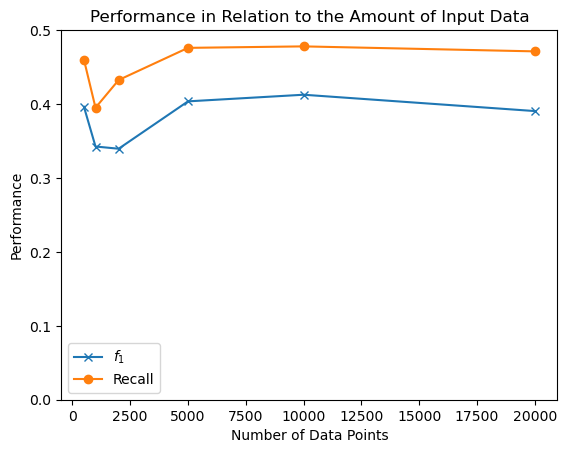

In [41]:
plt.plot(result_metrics['n_rows'],result_metrics['f1'],'x-', label='$f_1$');
#plt.plot(result_metrics['n_rows'],result_metrics['accuracy'], label='Accuracy');
plt.plot(result_metrics['n_rows'],result_metrics['recall'],'o-', label='Recall');
plt.title('Performance in Relation to the Amount of Input Data')
plt.xlabel('Number of Data Points')
plt.ylabel('Performance')
plt.ylim((0,0.5))
plt.legend();